# Specific Test V. Exploring transformers
The following notebook is my solution for Specific Test V

In this notebook, I explore the use of transformers for anomaly detection in strong lensing images with no substructure. Anomaly detection is the process to find data which are out-of-distribution from a population. To do this, we must first find the population statistics of given data and then find anomalies. These anomalous data point are also known as outliers. 

In [2]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from collections import OrderedDict
from torchvision import transforms
from torchvision.datasets import ImageFolder
from datasets import load_dataset
from transformers import DefaultDataCollator
from torchvision.models.vision_transformer import VisionTransformer
import seaborn as sns

# Dataset preprocessing

I use huggingface datasets to load the images and split them into a 90/10 train-test split. I use the pytorch Dataset class to build a custom dataset and the pytorch-lightning data loader to automate batch creation and shuffling. One thing to note is that we are not augumenting the dataset because it might introduce out-of-distribution data, thus weakening our model. However, I have trained a model on augumented data (commented in Dataset class). The weights will be made available

In [70]:
dataset = load_dataset("imagefolder", data_dir="lenses/no_sub")

Resolving data files:   0%|          | 0/5000 [00:00<?, ?it/s]

Found cached dataset imagefolder (/root/.cache/huggingface/datasets/imagefolder/default-11259632d3e97975/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [71]:
dataset = dataset['train'].train_test_split(test_size=0.1, seed = 10)

Loading cached split indices for dataset at /root/.cache/huggingface/datasets/imagefolder/default-11259632d3e97975/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-04085f3e297da81f.arrow and /root/.cache/huggingface/datasets/imagefolder/default-11259632d3e97975/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-c70321bfe7670454.arrow


In [72]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 4500
    })
    test: Dataset({
        features: ['image'],
        num_rows: 500
    })
})

In [73]:
class LensDataset(Dataset):

    def __init__(self, dataset):
        # Transforms
        self.dataset = dataset
        self.to_tensor = transforms.ToTensor()
        # self.transform_to_apply = [
        #     transforms.RandomHorizontalFlip(),
        #     transforms.RandomVerticalFlip(),
        #     transforms.RandomRotation(15),
        #     transforms.RandomRotation([-90, +90]),
        # ]
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.to_tensor(self.dataset[idx]['image'])
        return image

In [74]:
class LensDataModule(pl.LightningDataModule):
    def __init__(
        self,
        dataset,
        batch_size = 16,
        dataloader_num_workers = 1,
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.dataloader_num_workers = dataloader_num_workers
        self.train_dataset = dataset['train']
        self.test_dataset = dataset['test']

    def train_dataloader(self):
        
        return DataLoader(
            LensDataset(self.train_dataset),
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=self.dataloader_num_workers
        )
    
    def test_dataloader(self):
        return DataLoader(
            LensDataset(self.test_dataset),
            batch_size=self.batch_size,
            pin_memory=True,
            num_workers=self.dataloader_num_workers
        )


# Model creation and training

The model consists of 2 parts, the transformer and the decoder. For downstream tasks, the transformer uses special cls token embedding for the mlp head. For our case, I discard the mlp head and use the patch attention values for reconstructing the image. 

The patch attention values are passed to a decoder which uses pixel-shuffler layers to upscale to image to the original resolution. An MSE loss is used to train the transformer and the decoder

In [75]:
class ViT(VisionTransformer):
    def __init__(self,image_size = 150, patch_size = 30, num_layers = 6, num_heads = 6, hidden_dim = 900, mlp_dim = 192):
        super().__init__(image_size, patch_size, num_layers, num_heads, hidden_dim, mlp_dim)
        
        self.n_patches = self.image_size // self.patch_size
        
        self.conv_proj = nn.Conv2d(1, hidden_dim, kernel_size=(patch_size, patch_size), stride=(patch_size, patch_size))
        self.heads = None
        
    def forward(self, x: torch.Tensor):
        # Reshape and permute the input tensor
        x = self._process_input(x)
        n = x.shape[0]

        # Expand the class token to the full batch
        batch_class_token = self.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)
        x = self.encoder(x)
        x = x[:,1:]
        
        
        
        return x.view(-1, x.shape[2], self.n_patches, self.n_patches)


In [76]:
class Decoder(nn.Module):
    
    def __init__(self, channels = 900):
        
        super().__init__()
        self.pixel_shuffle1 = nn.PixelShuffle(upscale_factor = 3)
        self.conv1 = nn.Conv2d(channels//9, channels//9, kernel_size = (5, 5), padding = "same")
        self.bn1 = nn.BatchNorm2d(channels//9)
        self.prelu1 = nn.PReLU()
        
        self.pixel_shuffle2 = nn.PixelShuffle(upscale_factor = 5)
        self.conv2 = nn.Conv2d(channels//225, channels//225, kernel_size = (5, 5), padding = "same")
        self.bn2 = nn.BatchNorm2d(channels//225)
        self.prelu2 = nn.PReLU()
        
        self.pixel_shuffle3 = nn.PixelShuffle(upscale_factor = 2)
        
    def forward(self, x):
    
        x = self.bn1(self.prelu1(self.conv1(self.pixel_shuffle1(x))))
        x = self.bn2(self.prelu2(self.conv2(self.pixel_shuffle2(x))))
        
        return self.pixel_shuffle3(x)
        
        

In [77]:
class ViTAD(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.vit = ViT()
        self.decoder = Decoder()
        self.criterion = nn.MSELoss()
        
    def forward(self, x, fw="reconstruction"):
        
        if fw == "reconstruction":
            return self.decoder(self.vit(x))
        else:
            return self.vit(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0005)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 5)
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "train_loss"}
    
    
    def training_step(self, batch, batch_idx):
        x = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, x)
        self.log("train_loss", loss.item(), prog_bar=True)
        return loss
        
    def test_step(self, batch, batch_idx):
        x = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, x)
        return loss
        
    def predict_step(self, batch, batch_idx):
        x = batch
        pred = self(x)
        return pred, x
    

In [78]:
data_module = LensDataModule(dataset)
model = ViTAD()

In [79]:
trainer = pl.Trainer(max_epochs = 50, accelerator = "gpu", enable_progress_bar = True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [80]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | vit       | ViT     | 22.4 M
1 | decoder   | Decoder | 250 K 
2 | criterion | MSELoss | 0     
--------------------------------------
22.7 M    Trainable params
0         Non-trainable params
22.7 M    Total params
90.604    Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [14]:
# torch.save(model.state_dict(), open("anomaly_vit.model", "wb"))
# model.load_state_dict(torch.load(open("anomaly_vit.model", "rb")))

<All keys matched successfully>

In [81]:
model.eval()

ViTAD(
  (vit): ViT(
    (conv_proj): Conv2d(1, 900, kernel_size=(30, 30), stride=(30, 30))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((900,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=900, out_features=900, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((900,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=900, out_features=192, bias=True)
            (1): GELU(approximate=none)
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=192, out_features=900, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerNorm((900,), eps=1e-06, 

# Finding Anomalies

The anomalous images are those that arent part of the population distribution. The transformer auto-encoder learns the characteristic distribution of images to reconstruct them. If an anomalous image is to be reconstructed, the reconstruction will be poor and thus the mean squared error will be high, making it easy to identify the image. Thus, we must find a cutoff mse using our train set and apply it on the test set. We make use of the box-plot for identifying this limit.

In [82]:
true_images = []
pred_images = []

for data in data_module.test_dataloader():
    true_images.append(data)
    pred_images.append(model(data))

In [83]:
true_images = torch.cat(true_images, dim=0).detach().cpu().numpy()[:,0]
pred_images = torch.cat(pred_images, dim=0).detach().cpu().numpy()[:,0]

In [84]:
ssim(true_images, pred_images)

0.9971949243154644

In [85]:
psnr(true_images, pred_images)

47.533944899793724

In [86]:
mse = []
for data in data_module.train_dataloader():
    true_image = data.detach().cpu().numpy()
    pred_image = model(data).detach().cpu().numpy()
    for idx in range(true_image.shape[0]):
        mse.append(np.mean((true_image[idx] - pred_image[idx])**2))

<AxesSubplot: >

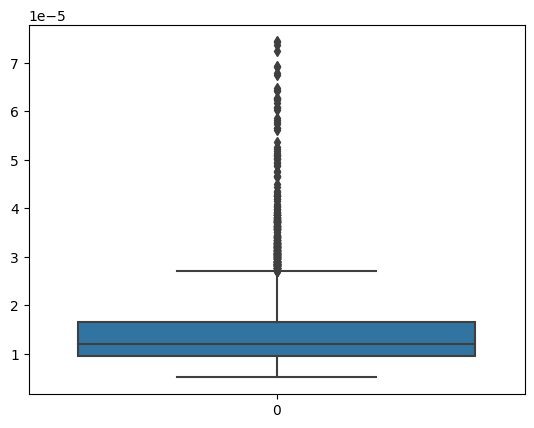

In [87]:
sns.boxplot(mse)

In [88]:
q3, q1 = np.percentile(mse, [75 ,25])

In [89]:
q4 = q3 + 1.5 * (q3 - q1)

In [90]:
print("limit mse:", q4)

limit mse: 2.703004963677813e-05


In [91]:
print("fraction of images detected as anomalies:", sum(np.array(mse) > q4)/len(mse) * 100)

fraction of images detected as anomalies: 6.688888888888888


Text(0, 0.5, 'mse')

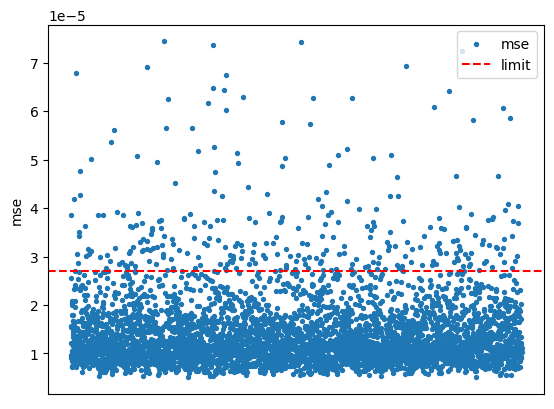

In [92]:
plt.scatter(range(len(mse)), mse, s = 8, label = "mse")
plt.axhline(y=q4, color='r', linestyle='--', label = "limit")
plt.legend()
plt.xticks([])
plt.ylabel("mse")

In [93]:
mse_test = []
for idx in range(true_images.shape[0]):
    
    mse_test.append(np.mean((true_images[idx] - pred_images[idx])**2))

In [94]:
print("fraction of images detected as anomalies:", sum(np.array(mse_test) > q4)/len(mse_test) * 100)

fraction of images detected as anomalies: 13.600000000000001


## Some anomalous images

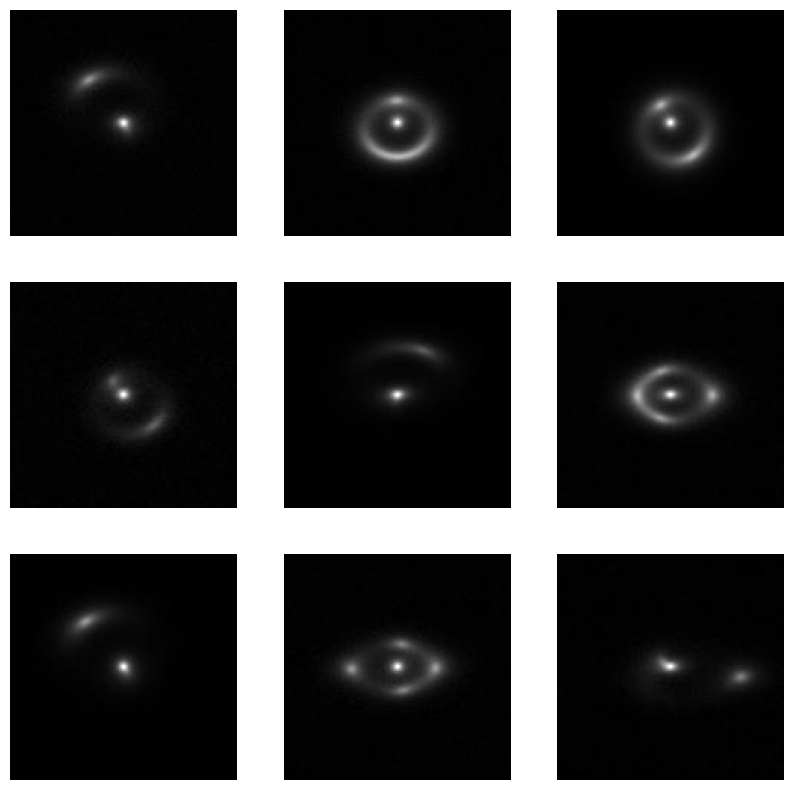

In [95]:
anomaly_images = true_images[np.array(mse_test) > q4]
plt.figure(figsize = (10,10))
for idx in range(12):
    
    if idx == 9:
        break
    plt.subplot(3, 3, idx+1)
    plt.imshow(anomaly_images[idx], cmap="gray")
    plt.axis("off")

## Some non-anomalous images

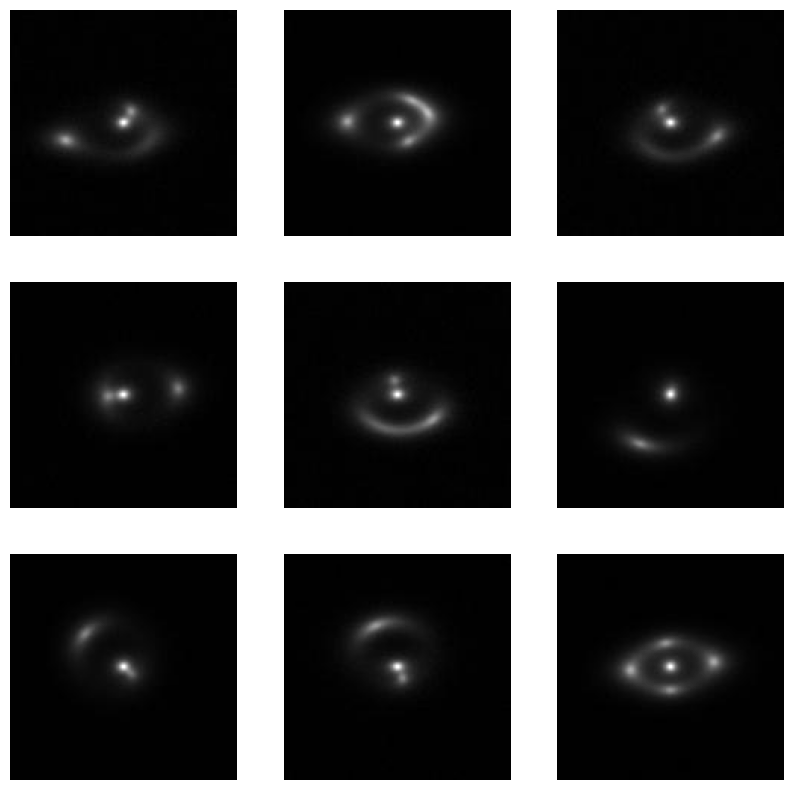

In [96]:
non_anomaly_images = true_images[np.array(mse_test) <= q4]
plt.figure(figsize = (10,10))
for idx in range(12):
    
    if idx == 9:
        break
    plt.subplot(3, 3, idx+1)
    plt.imshow(non_anomaly_images[idx], cmap="gray")
    plt.axis("off")